In [ ]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import os
import os.path
from os.path import join
import numpy as np
import imodelsx
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import seaborn as sns
import data
import joblib
files_dict = data.load_files_dict_single_site()

### Filter data for single-site analysis

In [ ]:
site = 'Atlanta'
# site = 'Columbus'
# site = 'WashingtonDC'
df = files_dict[site]
theme_index = np.where(
    np.array(list(map(str.lower, df.columns.values))) == 'theme')[0][0]
col_vals = df.columns[4: theme_index]

# separate into relevant pieces
qs = df['Subcategory']
responses_df = df[col_vals]
themes_df = df[df.columns[theme_index:]]

In [ ]:
question, responses, theme_dict = data.get_data_for_question_single_site(
    question_num=8, qs=qs, responses_df=responses_df, themes_df=themes_df)

In [ ]:
def numbered_list(classes):
    # return '\n'.join([f'Class {i+1}. {c}' for i, c in enumerate(classes)])
    return '\n'.join([f'{i+1}. {c}' for i, c in enumerate(classes)])


classification_prompt = '''### You are given a question, response, and a numbered list of themes below.

Question: {question}

Response: {response}

Themes:
{classes_as_numbered_list}

### Which of the themes does the response above belong to? Return the theme number.

Answer:'''

llm = imodelsx.llm.get_llm('gpt-4', repeat_delay=3)

In [ ]:
response = responses[1]
if len(theme_dict) > 1:
    assert not pd.isna(response)
    prompt = classification_prompt.format(
        question=question,
        classes_as_numbered_list=numbered_list(theme_dict.keys()),
        response=response,
    )
    print(prompt)
# llm(prompt)

In [ ]:
# screen valid questions
valid_question_nums = []
for question_num in tqdm(range(len(qs)), position=0):

    question, responses, theme_dict = data.get_data_for_question_single_site(
        question_num=question_num, qs=qs, responses_df=responses_df, themes_df=themes_df)

    # print(theme_dict)
    # valid only if there are multiple themes
    if len(theme_dict) > 1:

        # valid only if the number of theme values == number of non-null responses
        if sum(theme_dict.values()) == sum(responses.notna()):
            valid_question_nums.append(question_num)
        # assert sum(theme_dict.values()) == sum(responses.notna(
        # )), f'{sum(theme_dict.values())} != {sum(responses.notna())}, theme_dict: {theme_dict}, responses: {responses}\nquestion {question_num}: {question}'
print('num valid qs', len(valid_question_nums))

### Run classification

In [ ]:
classifications = defaultdict(list)
for question_num in tqdm(valid_question_nums, position=0):

    question, responses, theme_dict = data.get_data_for_question_single_site(
        question_num=question_num, qs=qs, responses_df=responses_df, themes_df=themes_df)

    for response_num in tqdm(range(len(responses)), position=1):
        response = responses.values[response_num]

        if not pd.isna(response):
            prompt = classification_prompt.format(
                question=question,
                classes_as_numbered_list=numbered_list(theme_dict.keys()),
                response=response,
            )
            ans = llm(prompt)
            classifications[question_num].append(ans)

### Compare acc

In [45]:
def process_classifications(x):
    # note, only works with <10 classes
    for i in range(1, 10):
        if x.startswith(str(i)):
            return i
    else:
        return 1


diffs = []
class_count_pred = []
class_count_gt = []
for question_num in valid_question_nums:
    question, responses, theme_dict = data.get_data_for_question_single_site(
        question_num=question_num, qs=qs, responses_df=responses_df, themes_df=themes_df)

    answer_counts = theme_dict.values()
    class_counts = pd.Series(classifications[question_num]).apply(
        process_classifications).value_counts()

    # convert value_counts to dict
    answer_counts_dict = {i + 1: round(v)
                          for i, v in enumerate(theme_dict.values())}
    class_counts_dict = {k: round(v) for k, v in class_counts.items()}
    for i in answer_counts_dict.keys():
        if i not in class_counts_dict:
            class_counts_dict[i] = 0

    # print(answer_counts_dict)
    # print(class_counts_dict)
    # print()

    class_count_pred += list(class_counts_dict.values())
    class_count_gt += list(answer_counts_dict.values())

    diffs.append(np.sum(np.abs(np.array(list(answer_counts_dict.values())) -
                               np.array(list(class_counts_dict.values())))))

n = max(class_count_gt + class_count_pred)
mat = np.zeros((n, n))
for i, j in zip(class_count_pred, class_count_gt):
    mat[i - 1, j - 1] += 1
joblib.dump(mat, join(data.PROCESSED_DIR,
            f'classification_confusion_matrix_{site}.pkl'))

['/home/chansingh/pedidose-efic-analysis/processed/classification_confusion_matrix_Atlanta.jl']

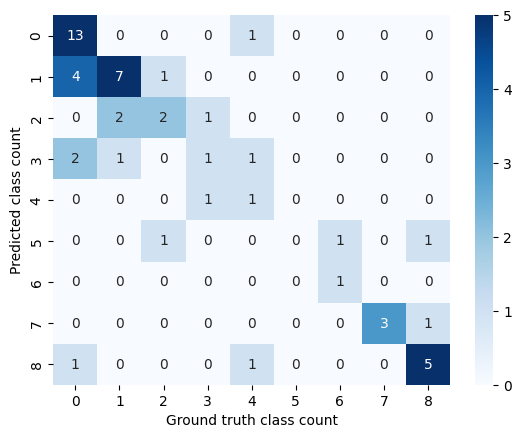

In [43]:
# differences
# plt.hist(diffs)

# Counts as scatter plot
# plt.plot(class_count_gt, class_count_pred, 'o', alpha=0.05)
# plt.xlabel('Ground Truth Class Count')
# plt.ylabel('Predicted Class Count')


sns.heatmap(mat, annot=True, fmt='g', vmax=5, cmap='Blues')
plt.ylabel('Predicted class count')
plt.xlabel('Ground truth class count')

plt.savefig('../figs/classification_heatmap.pdf', bbox_inches='tight')
plt.show()